In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats

#importing my acquire script
import acquire

# Viz imports
import matplotlib.pyplot as plt

In [2]:
# reading in telco churn data using function in acquire module
telco_df = acquire.get_telco_data()
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


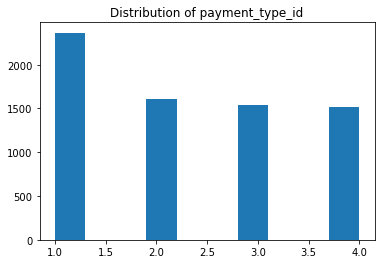

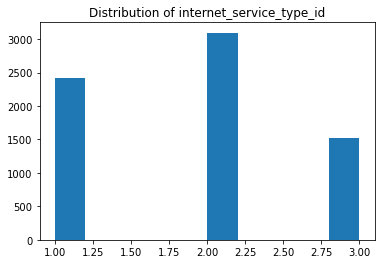

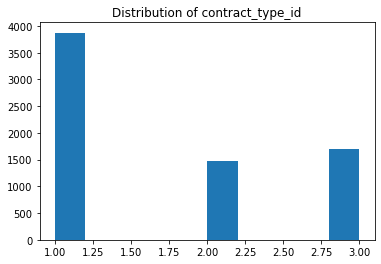

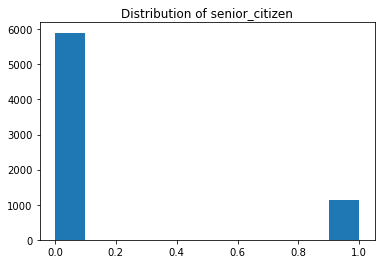

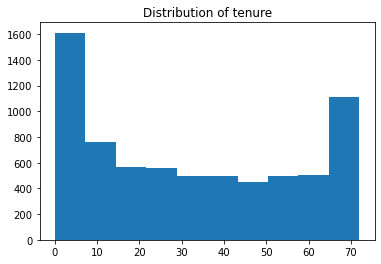

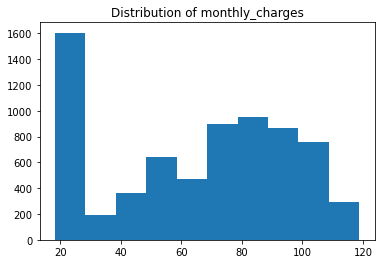

In [3]:
# describes the df, object and numeric cols
# acquire.get_data_summary(telco_df)

# shows distribution of individual variables
acquire.get_viz(telco_df)

### Acquire Takeaways:
- Churn is our target variable
- payment_type_id == payment type. We will keep the payment type id column since that is numeric
- internet_service type id column is the same as internet service type column. We will keep the internet service type id column since that is numeric
- contract type id column is the same as contract type column. We will keep the contract type id column since that is numeric 
- binary categorical columns like gender, partner, dependents will have to be encoded to be numeric
- total charges column has an object dtype - will have to change to float
- we will drop the customer id column 